### LASSO parameter range experiments, single gene

`scikit-learn` has two different implementations of logistic regression: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (using the `liblinear` coordinate descent optimizer) and [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (using stochastic gradient descent for optimization).

In this script we want to compare their performance and model selection dynamics across different levels of regularization, in depth for a single gene in our cancer gene set.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll_lr_range', 'gene'
)

sgd_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd_lr_constant_search', 'gene'
)

plot_gene = 'TP53'
metric = 'aupr'

output_plots = False
output_plots_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'optimizers_plots'
)

### Get nonzero coefficient information for each lasso penalty

In [3]:
ll_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
ll_nz_coefs_df = pd.DataFrame(
    ll_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)
ll_nz_coefs_df = ll_nz_coefs_df[ll_nz_coefs_df.gene == plot_gene].copy()
ll_nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs
0,TP53,classify,0.1,1,0,1165
1,TP53,classify,0.1,1,1,1063
2,TP53,classify,0.1,1,2,1104
3,TP53,classify,0.1,1,3,1156
4,TP53,classify,3160000.0,1,0,15391


In [4]:
sgd_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
sgd_nz_coefs_df = pd.DataFrame(
    sgd_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)
sgd_nz_coefs_df = sgd_nz_coefs_df[sgd_nz_coefs_df.gene == plot_gene].copy()
sgd_nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs
0,TP53,classify,0.0316,1,0,74
1,TP53,classify,0.0316,1,1,186
2,TP53,classify,0.0316,1,2,123
3,TP53,classify,0.0316,1,3,52
4,TP53,classify,0.3160,42,0,0


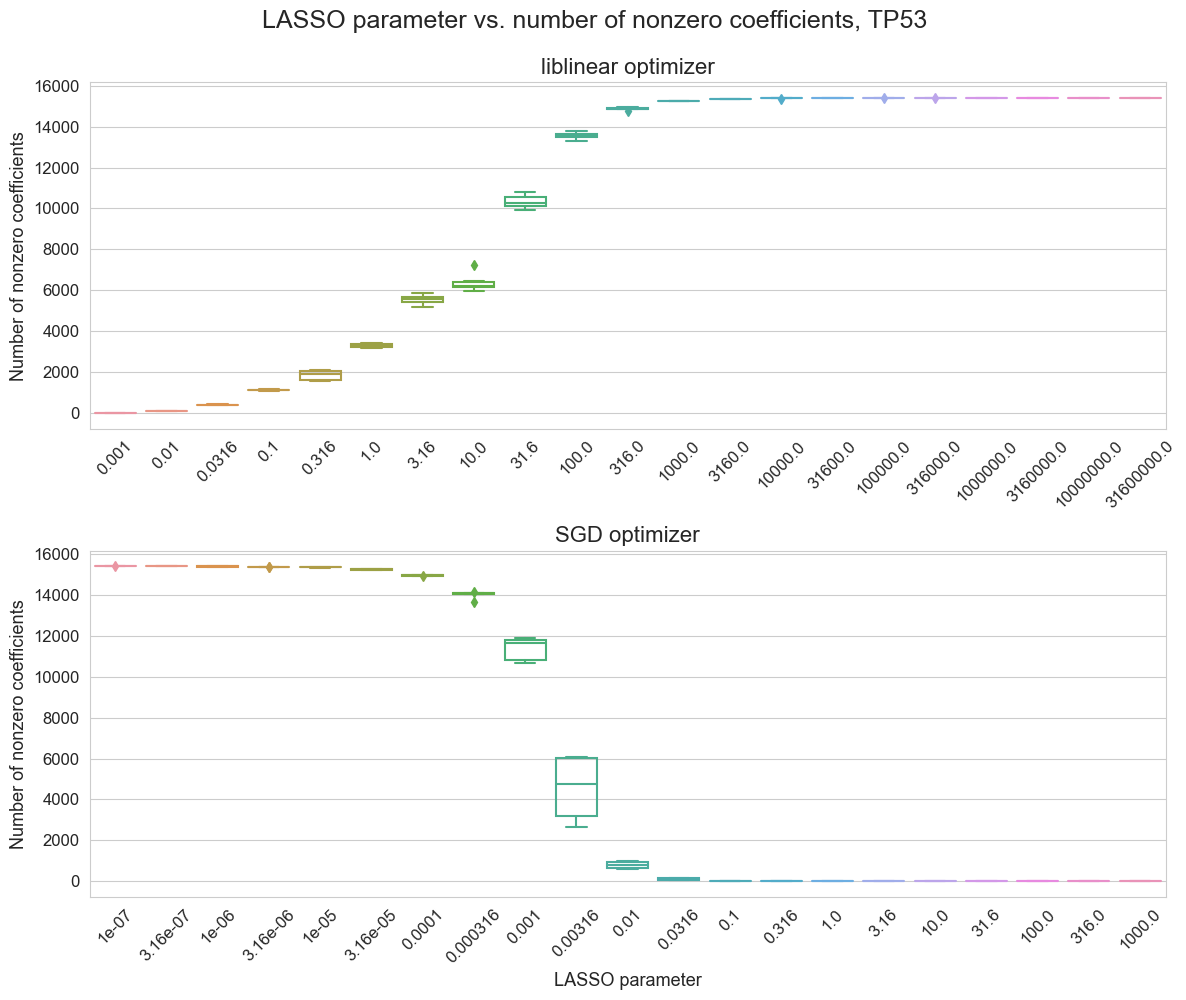

In [5]:
sns.set({'figure.figsize': (12, 10)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 1)

sns.boxplot(
    data=ll_nz_coefs_df.sort_values(by=['lasso_param']),
    x='lasso_param', y='nz_coefs', ax=axarr[0]
)
axarr[0].set_title('liblinear optimizer', size=16)
axarr[0].set_xlabel('')
axarr[0].set_ylabel('Number of nonzero coefficients', size=13)
axarr[0].tick_params(axis='both', labelsize=12)
axarr[0].tick_params(axis='x', rotation=45)

sns.boxplot(
    data=sgd_nz_coefs_df.sort_values(by=['lasso_param']),
    x='lasso_param', y='nz_coefs', ax=axarr[1]
)
axarr[1].set_title('SGD optimizer', size=16)
axarr[1].set_xlabel('LASSO parameter', size=13)
axarr[1].set_ylabel('Number of nonzero coefficients', size=13)
axarr[1].tick_params(axis='both', labelsize=12)
axarr[1].tick_params(axis='x', rotation=45)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
def color_boxes(ax):
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
            
color_boxes(axarr[0])
color_boxes(axarr[1])

plt.suptitle(
    f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}',
    size=18, y=0.995
)

plt.tight_layout()

if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_coefs_count.svg'), bbox_inches='tight')

### Get coefficient magnitude information for each lasso penalty

### Get performance information for each lasso penalty

### Bin models by nonzero coefficients

We'll try doing this both linearly (just 10 evenly spaced bins) and based on the deciles of the nonzero coefficient distributions.

In [11]:
ll_nz_coefs_df['optimizer'] = 'liblinear'
sgd_nz_coefs_df['optimizer'] = 'SGD'

nz_coefs_df = pd.concat((ll_nz_coefs_df, sgd_nz_coefs_df))
nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs,optimizer
0,TP53,classify,0.1,1,0,1165,liblinear
1,TP53,classify,0.1,1,1,1063,liblinear
2,TP53,classify,0.1,1,2,1104,liblinear
3,TP53,classify,0.1,1,3,1156,liblinear
4,TP53,classify,3160000.0,1,0,15391,liblinear


In [12]:
perf_coefs_df = (plot_df
    .merge(nz_coefs_df,
           left_on=['gene', 'optimizer', 'lasso_param', 'seed', 'fold'],
           right_on=['gene', 'optimizer', 'lasso_param', 'seed', 'fold'])
)

print(perf_coefs_df.shape)
perf_coefs_df.head()

(1008, 11)


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs
0,0.5,0.45797,TP53,signal,42,test,3,0.001,liblinear,classify,0
1,0.5,0.47590,TP53,signal,42,train,3,0.001,liblinear,classify,0
2,0.5,0.49500,TP53,signal,42,cv,3,0.001,liblinear,classify,0
3,0.5,0.47090,TP53,signal,1,train,3,0.001,liblinear,classify,0
4,0.5,0.48031,TP53,signal,1,test,3,0.001,liblinear,classify,0


,quantile,value
0,0.1,0.0
1,0.2,0.0
2,0.3,404.1
3,0.4,3298.0
4,0.5,10739.0
5,0.6,14937.0
6,0.7,15348.9
7,0.8,15388.0
8,0.9,15391.0


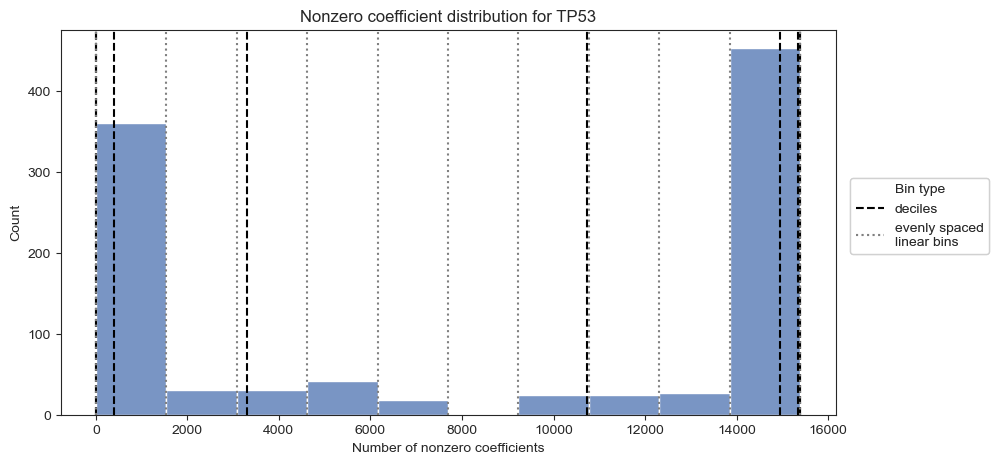

In [13]:
sns.set({'figure.figsize': (10, 5)})
sns.set_style('ticks')
sns.histplot(perf_coefs_df.nz_coefs, bins=10)
plt.title(f'Nonzero coefficient distribution for {plot_gene}')
plt.xlabel('Number of nonzero coefficients')

quantiles_df = []
ax = plt.gca()

# visualize quantile boundaries
for q in np.linspace(0.1, 0.9, 9):
    quantiles_df.append([q, perf_coefs_df.nz_coefs.quantile(q)])
    ax.axvline(x=perf_coefs_df.nz_coefs.quantile(q),
                      color='black', linestyle='--')
    
# visualize linear bins
for b in np.linspace(0, perf_coefs_df.nz_coefs.max(), 11):
    ax.axvline(x=b, color='grey', linestyle=':')
    
# create custom legend for bin boundary lines
legend_handles = [
    Line2D([0], [0], color='black', linestyle='--'),
    Line2D([0], [0], color='grey', linestyle=':'),
]
legend_labels = ['deciles', 'evenly spaced\nlinear bins']
l = ax.legend(legend_handles, legend_labels, title='Bin type',
              loc='lower left', bbox_to_anchor=(1.01, 0.4))
ax.add_artist(l)

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_coefs_dist.svg'), bbox_inches='tight')
    
quantiles_df = pd.DataFrame(quantiles_df, columns=['quantile', 'value'])
quantiles_df

### Map regularization parameters to bins

We just want to visualize which parameters map to which bins, in both the linear and decile cases.

In [14]:
perf_coefs_df['nz_linear_bin'] = pd.cut(
    perf_coefs_df.nz_coefs,
    bins=np.linspace(0, perf_coefs_df.nz_coefs.max(), 11),
    labels=[f'{q}' for q in range(1, 11)],
    include_lowest=True
)

print(perf_coefs_df.nz_linear_bin.unique().sort_values())
perf_coefs_df.head()

['1', '2', '3', '4', '5', '7', '8', '9', '10']
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs,nz_linear_bin
0,0.5,0.45797,TP53,signal,42,test,3,0.001,liblinear,classify,0,1
1,0.5,0.47590,TP53,signal,42,train,3,0.001,liblinear,classify,0,1
2,0.5,0.49500,TP53,signal,42,cv,3,0.001,liblinear,classify,0,1
3,0.5,0.47090,TP53,signal,1,train,3,0.001,liblinear,classify,0,1
4,0.5,0.48031,TP53,signal,1,test,3,0.001,liblinear,classify,0,1


In [15]:
ll_param_bin_map = (perf_coefs_df
    [perf_coefs_df.optimizer == 'liblinear']
).loc[:, ['lasso_param', 'nz_linear_bin']]

(ll_param_bin_map
   .drop_duplicates()
   .groupby('lasso_param')
)['nz_linear_bin'].apply(list)

lasso_param
1.000000e-03       [1]
1.000000e-02       [1]
3.160000e-02       [1]
1.000000e-01       [1]
3.160000e-01       [2]
1.000000e+00       [3]
3.160000e+00       [4]
1.000000e+01    [5, 4]
3.160000e+01    [7, 8]
1.000000e+02       [9]
3.160000e+02      [10]
1.000000e+03      [10]
3.160000e+03      [10]
1.000000e+04      [10]
3.160000e+04      [10]
1.000000e+05      [10]
3.160000e+05      [10]
1.000000e+06      [10]
3.160000e+06      [10]
1.000000e+07      [10]
3.160000e+07      [10]
Name: nz_linear_bin, dtype: object

In [16]:
sgd_param_bin_map = (perf_coefs_df
    [perf_coefs_df.optimizer == 'SGD']
).loc[:, ['lasso_param', 'nz_linear_bin']]

(sgd_param_bin_map
   .drop_duplicates()
   .groupby('lasso_param')
)['nz_linear_bin'].apply(list)

lasso_param
1.000000e-07         [10]
3.160000e-07         [10]
1.000000e-06         [10]
3.160000e-06         [10]
1.000000e-05         [10]
3.160000e-05         [10]
1.000000e-04         [10]
3.160000e-04      [10, 9]
1.000000e-03       [8, 7]
3.160000e-03    [3, 4, 2]
1.000000e-02          [1]
3.160000e-02          [1]
1.000000e-01          [1]
3.160000e-01          [1]
1.000000e+00          [1]
3.160000e+00          [1]
1.000000e+01          [1]
3.160000e+01          [1]
1.000000e+02          [1]
3.160000e+02          [1]
1.000000e+03          [1]
Name: nz_linear_bin, dtype: object

[31600000.0, 10000000.0, 3160000.0, 1000000.0, 316000.0, 100000.0, 31600.0, 10000.0, 3160.0, 1000.0, 316.0, 100.0, 31.6, 10.0, 3.16, 1.0, 0.316, 0.1, 0.0316, 0.01, 0.00316, 0.001, 0.000316, 0.0001, 3.16e-05, 1e-05, 3.16e-06, 1e-06, 3.16e-07, 1e-07]


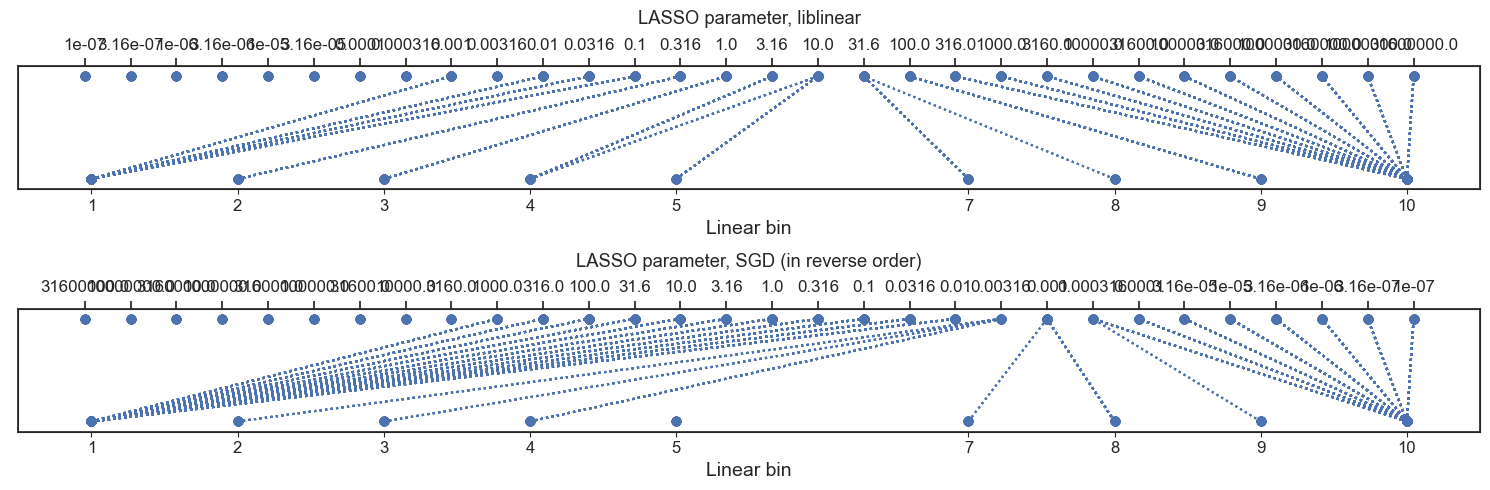

In [17]:
sns.set({'figure.figsize': (15, 5)})
sns.set_style('ticks')

fig, axarr = plt.subplots(2, 1)

param_bin_map = perf_coefs_df.loc[:, ['lasso_param', 'nz_linear_bin']]

# ax1 is the bin axis for liblinear
with sns.plotting_context('notebook', font_scale=1.1):
    ax1 = axarr[0]
    ax1.scatter(x=param_bin_map.nz_linear_bin.astype(int).values,
                y=[0] * param_bin_map.shape[0])
    ax1.set_xlim(param_bin_map.nz_linear_bin.astype(int).min() - 0.5,
                 param_bin_map.nz_linear_bin.astype(int).max() + 0.5)
    ax1.set_xticks(param_bin_map.nz_linear_bin.astype(int).unique())
    ax1.tick_params(axis='x', labelsize=12)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xlabel('Linear bin', size=14)

    ax2 = ax1.twiny()
    param_vals = param_bin_map.lasso_param.sort_values(ascending=True).astype(str)
    ax2.scatter(x=param_vals, y=[1] * param_bin_map.shape[0])
    ax2.set_xlabel('LASSO parameter, liblinear', labelpad=10)

    def bins_to_coords(bins):
        # TODO document
        x = np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], 11)
        # https://stackoverflow.com/a/23856065
        x_mid = (x[1:] + x[:-1]) / 2
        return {b: x_mid[int(b)-1] for b in bins}

    # iterate through all (param, bin) coordinates and use bin to index
    bins = param_bin_map.nz_linear_bin.astype(int).sort_values(ascending=True).unique().tolist()
    b_to_c = bins_to_coords(bins)

    unique_param_vals = param_vals.astype(float).unique().tolist()
    for ix, row in ll_param_bin_map.iterrows():
        bin_ix = int(row.nz_linear_bin)
        lasso_param_ix = unique_param_vals.index(row.lasso_param) 
        ax2.plot([b_to_c[bin_ix], lasso_param_ix], [0, 1], 'bo:')
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_yticks([0, 1])

    # ax3 is the bin axis for SGD
    ax3 = axarr[1]
    ax3.scatter(x=param_bin_map.nz_linear_bin.astype(int).values,
                y=[0] * param_bin_map.shape[0])
    ax3.set_xlim(param_bin_map.nz_linear_bin.astype(int).min() - 0.5,
                 param_bin_map.nz_linear_bin.astype(int).max() + 0.5)
    ax3.set_xticks(param_bin_map.nz_linear_bin.astype(int).unique())
    ax3.tick_params(axis='x', labelsize=12)
    ax3.get_yaxis().set_visible(False)
    ax3.set_xlabel('Linear bin', size=14)

    ax4 = ax3.twiny()
    param_vals = param_bin_map.lasso_param.sort_values(ascending=False).astype(str)
    ax4.scatter(x=param_vals, y=[1] * param_bin_map.shape[0])
    ax4.set_xlabel('LASSO parameter, SGD (in reverse order)', labelpad=10)

    unique_param_vals = param_vals.astype(float).unique().tolist()
    print(unique_param_vals)
    for ix, row in sgd_param_bin_map.iterrows():
        bin_ix = int(row.nz_linear_bin)
        lasso_param_ix = unique_param_vals.index(row.lasso_param) 
        ax4.plot([b_to_c[bin_ix], lasso_param_ix], [0, 1], 'bo:')
    ax3.set_ylim(-0.1, 1.1)
    ax3.set_yticks([0, 1])

plt.tight_layout()

In [18]:
# sometimes there are enough classifiers with O nonzero coefficients, or the
# max number of coefficients, such that they are covered by a whole decile
# in that case, we drop the duplicate deciles and combine them into one (so we'll
# have e.g. 9 bins instead of 10 deciles)
range_bounds = (0.0, float(perf_coefs_df.nz_coefs.max()))
print(range_bounds)

num_quantiles = quantiles_df[~quantiles_df.value.isin(range_bounds)].shape[0]
print(num_quantiles, 'unique quantiles')

perf_coefs_df['nz_quantile'] = pd.qcut(
    perf_coefs_df.nz_coefs,
    q=np.linspace(0, 1, 11),
    labels=[f'{q}' for q in range(1, num_quantiles+2)],
    duplicates='drop'
)

print(perf_coefs_df.nz_quantile.unique().sort_values())
perf_coefs_df.head()

(0.0, 15391.0)
6 unique quantiles
['1', '2', '3', '4', '5', '6', '7']
Categories (7, object): ['1' < '2' < '3' < '4' < '5' < '6' < '7']


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs,nz_linear_bin,nz_quantile
0,0.5,0.45797,TP53,signal,42,test,3,0.001,liblinear,classify,0,1,1
1,0.5,0.47590,TP53,signal,42,train,3,0.001,liblinear,classify,0,1,1
2,0.5,0.49500,TP53,signal,42,cv,3,0.001,liblinear,classify,0,1,1
3,0.5,0.47090,TP53,signal,1,train,3,0.001,liblinear,classify,0,1,1
4,0.5,0.48031,TP53,signal,1,test,3,0.001,liblinear,classify,0,1,1


In [19]:
ll_param_q_map = (perf_coefs_df
    [perf_coefs_df.optimizer == 'liblinear']                  
).loc[:, ['lasso_param', 'nz_quantile']]

(ll_param_q_map
   .drop_duplicates()
   .groupby('lasso_param')
)['nz_quantile'].apply(list)

lasso_param
1.000000e-03       [1]
1.000000e-02       [1]
3.160000e-02    [1, 2]
1.000000e-01       [2]
3.160000e-01       [2]
1.000000e+00    [2, 3]
3.160000e+00       [3]
1.000000e+01       [3]
3.160000e+01    [3, 4]
1.000000e+02       [4]
3.160000e+02       [4]
1.000000e+03       [5]
3.160000e+03    [5, 6]
1.000000e+04       [6]
3.160000e+04    [7, 6]
1.000000e+05    [7, 6]
3.160000e+05       [7]
1.000000e+06       [7]
3.160000e+06       [7]
1.000000e+07       [7]
3.160000e+07       [7]
Name: nz_quantile, dtype: object

In [20]:
sgd_param_q_map = (perf_coefs_df
    [perf_coefs_df.optimizer == 'SGD']                  
).loc[:, ['lasso_param', 'nz_quantile']]

(sgd_param_q_map
   .drop_duplicates()
   .groupby('lasso_param')
)['nz_quantile'].apply(list)

lasso_param
1.000000e-07       [7]
3.160000e-07       [7]
1.000000e-06    [7, 6]
3.160000e-06       [6]
1.000000e-05    [6, 5]
3.160000e-05       [5]
1.000000e-04    [5, 4]
3.160000e-04       [4]
1.000000e-03    [4, 3]
3.160000e-03    [3, 2]
1.000000e-02       [2]
3.160000e-02       [1]
1.000000e-01       [1]
3.160000e-01       [1]
1.000000e+00       [1]
3.160000e+00       [1]
1.000000e+01       [1]
3.160000e+01       [1]
1.000000e+02       [1]
3.160000e+02       [1]
1.000000e+03       [1]
Name: nz_quantile, dtype: object

[1e-07, 3.16e-07, 1e-06, 3.16e-06, 1e-05, 3.16e-05, 0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0, 3.16, 10.0, 31.6, 100.0, 316.0, 1000.0, 3160.0, 10000.0, 31600.0, 100000.0, 316000.0, 1000000.0, 3160000.0, 10000000.0, 31600000.0]
[31600000.0, 10000000.0, 3160000.0, 1000000.0, 316000.0, 100000.0, 31600.0, 10000.0, 3160.0, 1000.0, 316.0, 100.0, 31.6, 10.0, 3.16, 1.0, 0.316, 0.1, 0.0316, 0.01, 0.00316, 0.001, 0.000316, 0.0001, 3.16e-05, 1e-05, 3.16e-06, 1e-06, 3.16e-07, 1e-07]


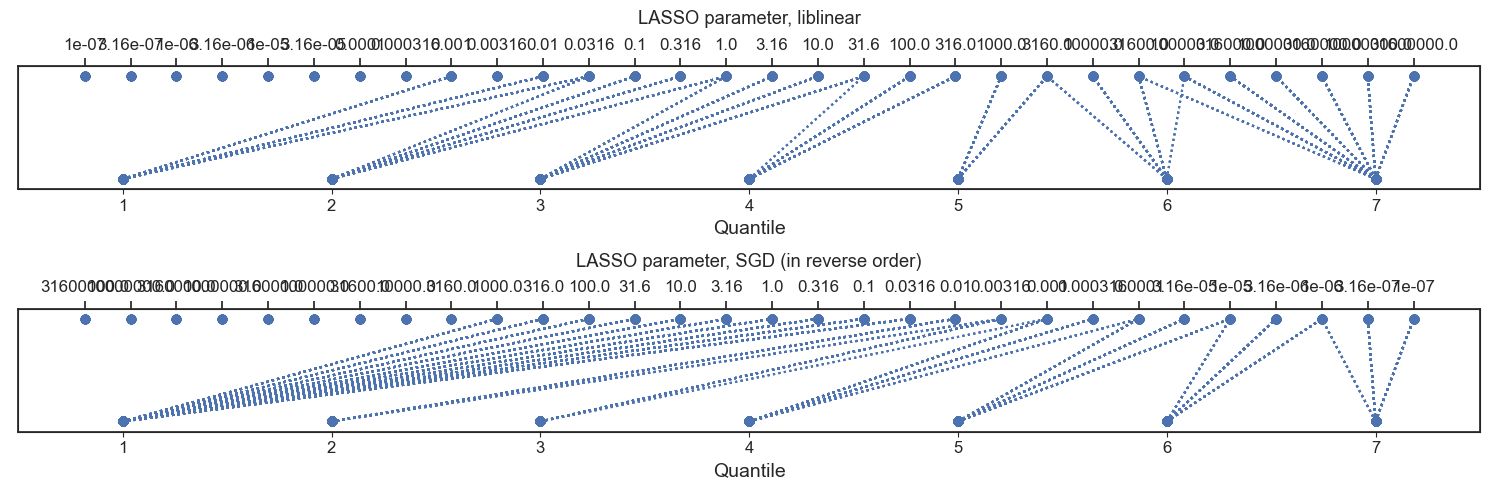

In [21]:
sns.set({'figure.figsize': (15, 5)})
sns.set_style('ticks')

fig, axarr = plt.subplots(2, 1)

param_q_map = perf_coefs_df.loc[:, ['lasso_param', 'nz_quantile']]

with sns.plotting_context('notebook', font_scale=1.1):
    # ax1 is the bin axis for liblinear
    ax1 = axarr[0]
    ax1.scatter(x=param_q_map.nz_quantile.astype(int).values,
                y=[0] * param_q_map.shape[0])
    ax1.set_xlim(param_q_map.nz_quantile.astype(int).min() - 0.5,
                 param_q_map.nz_quantile.astype(int).max() + 0.5)
    ax1.set_xticks(param_q_map.nz_quantile.astype(int).unique())
    ax1.tick_params(axis='x', labelsize=12)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xlabel('Quantile', size=14)

    ax2 = ax1.twiny()
    param_vals = param_q_map.lasso_param.sort_values(ascending=True).astype(str)
    ax2.scatter(x=param_vals, y=[1] * param_q_map.shape[0])
    ax2.set_xlabel('LASSO parameter, liblinear', labelpad=10)

    def bins_to_coords(bins):
        # TODO document
        x = np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], len(perf_coefs_df.nz_quantile.unique())+1)
        # https://stackoverflow.com/a/23856065
        x_mid = (x[1:] + x[:-1]) / 2
        return {b: x_mid[int(b)-1] for b in bins}

    # iterate through all (param, bin) coordinates and use bin to index
    qs = param_q_map.nz_quantile.astype(int).sort_values(ascending=True).unique().tolist()
    b_to_c = bins_to_coords(qs)

    unique_param_vals = param_vals.astype(float).unique().tolist()
    print(unique_param_vals)
    for ix, row in ll_param_q_map.iterrows():
        bin_ix = int(row.nz_quantile)
        lasso_param_ix = unique_param_vals.index(row.lasso_param) 
        ax2.plot([b_to_c[bin_ix], lasso_param_ix], [0, 1], 'bo:')
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_yticks([0, 1])

    # ax3 is the bin axis for SGD
    ax3 = axarr[1]
    ax3.scatter(x=param_q_map.nz_quantile.astype(int).values,
                y=[0] * param_q_map.shape[0])
    ax3.set_xlim(param_q_map.nz_quantile.astype(int).min() - 0.5,
                 param_q_map.nz_quantile.astype(int).max() + 0.5)
    ax3.set_xticks(param_q_map.nz_quantile.astype(int).unique())
    ax3.tick_params(axis='x', labelsize=12)
    ax3.get_yaxis().set_visible(False)
    ax3.set_xlabel('Quantile', size=14)

    ax4 = ax3.twiny()
    param_vals = param_q_map.lasso_param.sort_values(ascending=False).astype(str)
    ax4.scatter(x=param_vals, y=[1] * param_q_map.shape[0])
    ax4.set_xlabel('LASSO parameter, SGD (in reverse order)', labelpad=10)

    unique_param_vals = param_vals.astype(float).unique().tolist()
    print(unique_param_vals)
    for ix, row in sgd_param_q_map.iterrows():
        bin_ix = int(row.nz_quantile)
        lasso_param_ix = unique_param_vals.index(row.lasso_param) 
        ax4.plot([b_to_c[bin_ix], lasso_param_ix], [0, 1], 'bo:')
    ax3.set_ylim(-0.1, 1.1)
    ax3.set_yticks([0, 1])

plt.tight_layout()

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_parameter_to_decile.svg'), bbox_inches='tight')

### Plot performance vs. nonzero coefficient bin

This allows us to compare liblinear and SGD using variation on the same axis (sparsity/number of nonzero coefficients), rather than comparing in parameter space since the regularization parameters vary in opposite directions.

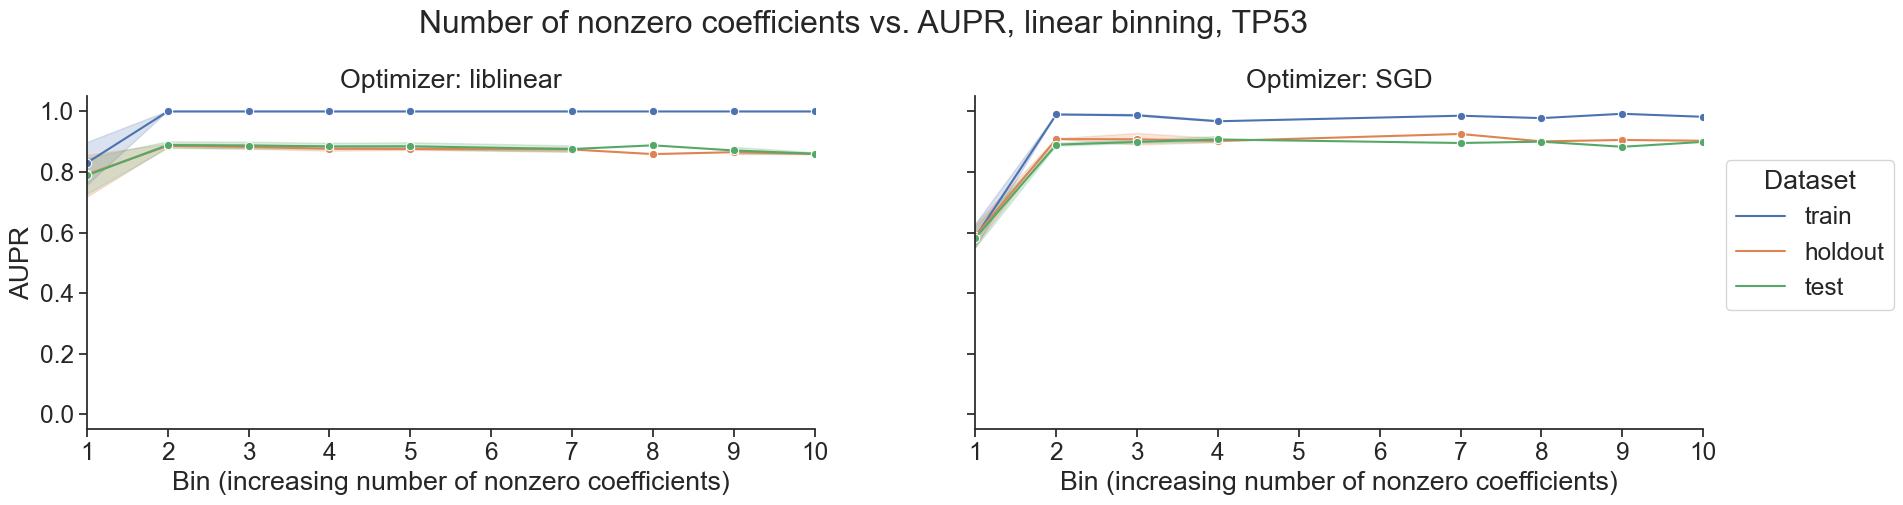

In [22]:
sns.set_style('ticks')

ll_plot_df = (
    perf_coefs_df[(perf_coefs_df.optimizer == 'liblinear')]
      .sort_values(by=['nz_linear_bin'])
      .reset_index(drop=True)
)

sgd_plot_df = (
    perf_coefs_df[(perf_coefs_df.optimizer == 'sgd')]
      .sort_values(by=['nz_linear_bin'])
      .reset_index(drop=True)
)

plot_df = pd.concat((ll_plot_df, sgd_plot_df))

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=perf_coefs_df,
        x='nz_linear_bin', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.axes[0].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[0].set_xlim((0, perf_coefs_df.nz_linear_bin.max()))
    g.axes[0].set_ylim((-0.05, 1.05))
    g.axes[1].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[1].set_xlim((0, perf_coefs_df.nz_linear_bin.max()))
    g.axes[1].set_ylim((-0.05, 1.05))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.045, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(
        f'Number of nonzero coefficients vs. {metric.upper()}, linear binning, {plot_gene}',
        y=1.0
    )

plt.tight_layout(w_pad=10)

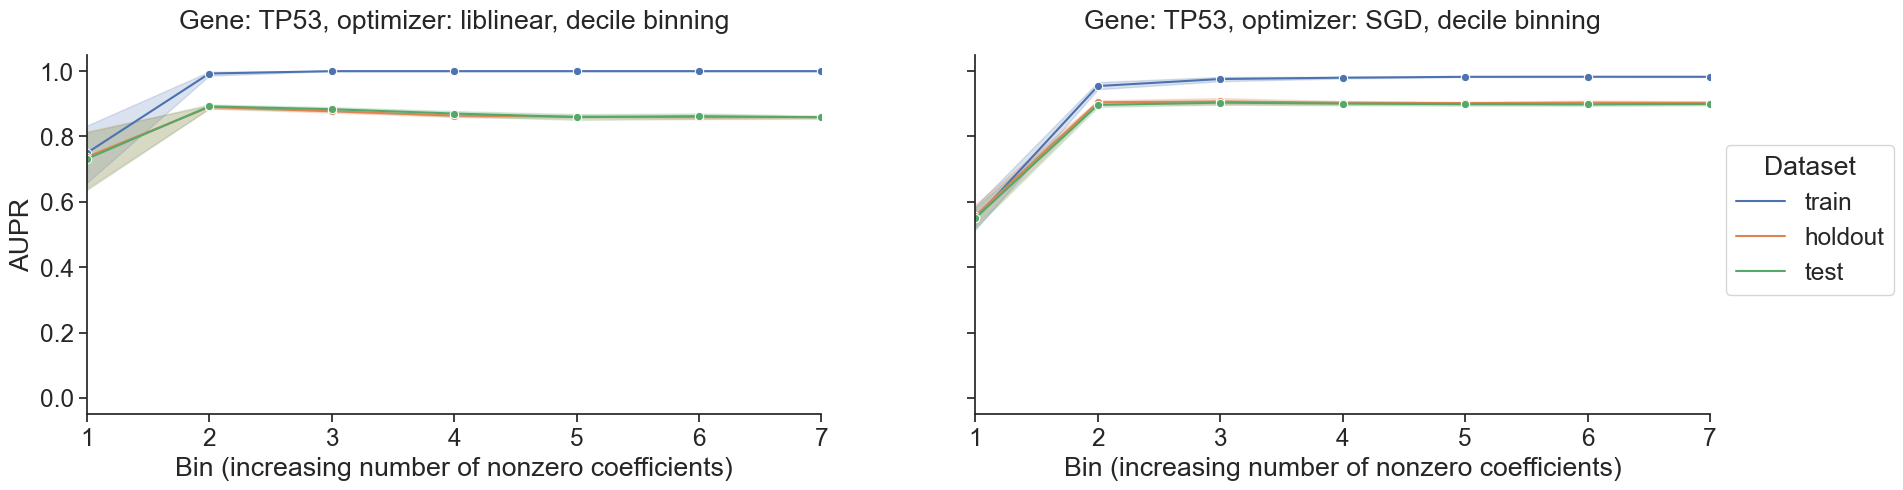

In [23]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=perf_coefs_df,
        x='nz_quantile', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.axes[0].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[0].set_xlim((0, perf_coefs_df.nz_quantile.max()))
    g.axes[0].set_ylim((-0.05, 1.05))
    g.axes[1].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[1].set_xlim((0, perf_coefs_df.nz_quantile.max()))
    g.axes[1].set_ylim((-0.05, 1.05))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.045, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Gene: {}, optimizer: {{col_name}}, decile binning'.format(plot_gene), y=1.05)

plt.tight_layout(w_pad=10)

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_decile_vs_perf.svg'), bbox_inches='tight')